In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import json
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val'+string])
    plt.show()

In [4]:
DATA_IN_PATH = './data-in/'
DATA_OUT_PATH = './data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [5]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [6]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb')) # 'rb' 이진데이터
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r')) # 'r' 아스키데이터

자연어처리에 cnn 원리 도입   
![Koran_model_cnn-for-sentence.png](Koran_model_cnn-for-sentence.png)

In [7]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {
    'model_name': model_name,
    'vocab_size': prepro_configs['vocab_size'],
    'embedding_size': 128,
    'num_filters': 100, #커널당 필터 100개
    'droupout_rate': 0.5,
    'hidden_dimension': 250,
    'output_dimension': 1
}

In [8]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(kargs['vocab_size'] + 1, kargs['embedding_size'])
        self.conv_list = [  #컨볼루션 층을 리스트로
            layers.Conv1D(kargs['num_filters'], 
                          kernel_size = kernel_size, 
                          activation ='relu', 
                          kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3.) #최대값 3으로 제한
                         ) # padding의 기본값은 'valid'임(생략가능)
            for kernel_size in [3, 4, 5]
        ] 
        self.pooling = layers.GlobalMaxPool1D()
        self.dropout = layers.Dropout(kargs['droupout_rate'])
        self.fc1 = layers.Dense(units = kargs['hidden_dimension'],
                                activation = 'relu',
                                kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3.))                               
        self.fc2 = layers.Dense(units = kargs['output_dimension'],
                                activation = 'sigmoid',
                                kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3.))                               
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        # conv 하나씩 뽑아내서 x를 한개씩 넣고 그것을 다시 pooling에 넣음
        # 리스트에 pooling 결과는 3개
        # axis=-1 맨 마지막층 (column기준으로 붙임)
        x = self.fc1(x) 
        x = self.fc2(x)        
        return x

In [9]:
model = CNNClassifier(**kargs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
# min_delta=0.0001 이상 증가해야 개선된 것으로 판단할것. 판단 기준 제공. 기본값은 0
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
    
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, 
                                   save_best_only=True, save_weights_only=True)

In [11]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                   validation_split=VALID_SPLIT, callbacks=[early_stop, model_checkpoint])

Epoch 1/10
263/264 [============================>.] - ETA: 0s - loss: 0.4586 - accuracy: 0.7763
Epoch 1: val_accuracy improved from -inf to 0.81960, saving model to ./data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 18s 61ms/step - loss: 0.4584 - accuracy: 0.7764 - val_loss: 0.3958 - val_accuracy: 0.8196
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8459
Epoch 2: val_accuracy improved from 0.81960 to 0.82940, saving model to ./data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 16s 60ms/step - loss: 0.3517 - accuracy: 0.8459 - val_loss: 0.3843 - val_accuracy: 0.8294
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.8722
Epoch 3: val_accuracy did not improve from 0.82940
264/264 [==============================] - 16s 59ms/step - loss: 0.3005 - accuracy: 0.8722 - val_loss: 0.3994 - val_accuracy: 0.8217
Epoch 4/10
263/264 [=====================

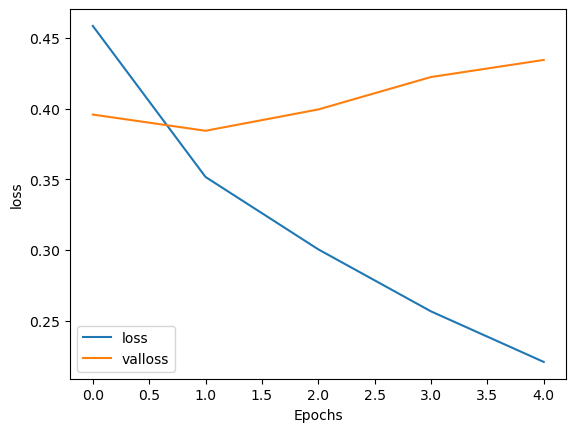

In [12]:
import matplotlib.pyplot as plt
plot_graphs(history, 'loss')

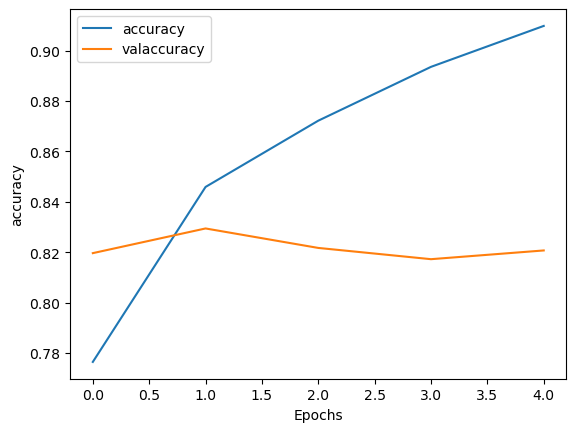

In [13]:
plot_graphs(history, 'accuracy')

In [14]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'

In [18]:
test_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb')) # 'rb' 이진데이터
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))

In [19]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, 'weights.h5'))

In [20]:
model.evaluate(test_input, test_label_data)

4688/4688 [==============================] - 8s 2ms/step - loss: 0.2833 - accuracy: 0.8838


[0.2832774817943573, 0.883846640586853]